In [1]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from scipy import stats
import plotly.express as px
import toml
import psrc_theme

%matplotlib inline
from IPython.display import display, HTML

# to show plotly figures in quarto HTML file
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.templates.default = "simple_white+psrc_color" # set plotly template

input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))
emme_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration','emme_configuration.toml'))
network_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration','network_configuration.toml'))

# create connection
conn = create_engine('sqlite:///inputs/db/'+input_config['db_name'])

# summary data location
csv_path = os.path.join(valid_config['model_dir'], 'outputs/validation')

# table format
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

## daily traffic counts

In [2]:
df = pd.read_csv(os.path.join(csv_path, 'daily_volume.csv'))
df[['modeled', 'observed']] = df[['modeled', 'observed']].astype('float')
_df = df.groupby('@facilitytype').sum()[['observed', 'modeled']]
_df.loc['Total', :] = _df.sum().values
_df['diff'] = _df['modeled'] - _df['observed']
_df['percent_diff'] = _df['diff'] / _df['observed']
_df[['percent_diff']] = _df[['percent_diff']].applymap(format_percent)
_df

,observed,modeled,diff,percent_diff
@facilitytype,,,,
Freeway,"3,992,676.00","4,366,244.00","373,568.00",9.36%
Ramp,"174,119.00","63,633.00","-110,486.00",-63.45%
Total,"4,166,795.00","4,429,877.00","263,082.00",6.31%


In [3]:
df = pd.read_csv(os.path.join(csv_path,'daily_volume_county_facility.csv'))
df[['modeled','observed']] = df[['modeled','observed']].astype('float')

_df = df.groupby('county').sum()[['observed','modeled']]
_df.loc['Total',:] = _df.sum().values
_df['diff'] = _df['modeled']-_df['observed']
_df['percent_diff'] = _df['diff']/_df['observed']
_df[['percent_diff']] = _df[['percent_diff']].applymap(format_percent)
_df

,observed,modeled,diff,percent_diff
county,,,,
King,"1,414,477.00","1,349,825.00","-64,652.00",-4.57%
Pierce,"2,752,318.00","3,080,052.00","327,734.00",11.91%
Total,"4,166,795.00","4,429,877.00","263,082.00",6.31%


## daily traffic scatterplot

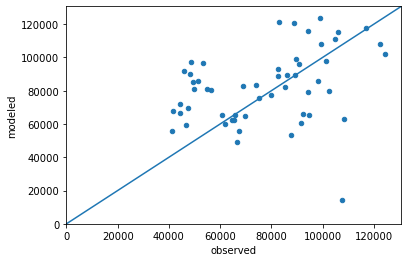

In [4]:
df = pd.read_csv(os.path.join(csv_path,'daily_volume.csv'))
ax = df.plot(kind='scatter', x='observed', y='modeled')
lim = df[['observed','modeled']].max().max()*1.05
ax.set_ylim(0,lim)
ax.set_xlim(0,lim)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)

In [5]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
print('r^2: ' + str(r_value))

r^2: 0.34389873330673504


King r^2: 0.07753028948052525
Pierce r^2: 0.18788916521782933


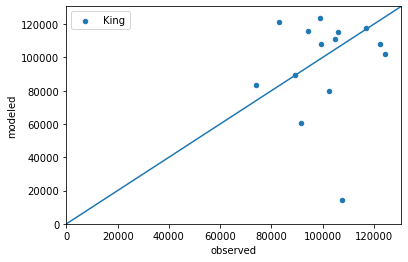

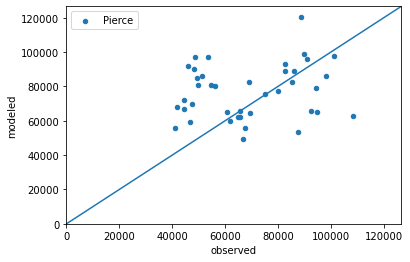

In [6]:
for county in np.unique(df['county']):
    _df = df[df['county'] == county]
    ax = _df.plot(kind='scatter', x='observed', y='modeled', label=county)
    lim = _df[['observed','modeled']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed'],_df['modeled'])
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    print(str(county) + ' r^2: ' + str(r_value))

In [7]:
df['@facilitytype'].unique()

array(['Freeway', 'Ramp'], dtype=object)

r^2 Freeway: 0.47593478729652205


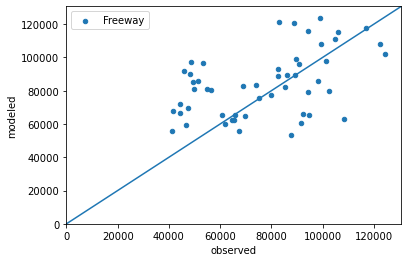

In [8]:
# for factype in ['Freeway','Arterial']:
for factype in ['Freeway']:
    _df = df[df['@facilitytype'] == factype]
    ax = _df.plot(kind='scatter', x='observed', y='modeled', label=factype)
    lim = _df[['observed','modeled']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed'],_df['modeled'])
    print('r^2 ' + str(factype) + ': ' + str(r_value))

## hourly volumnes

r^2: 0.6933683354306491


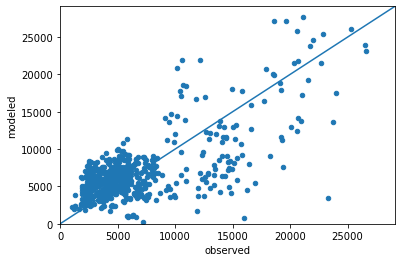

In [9]:
df = pd.read_csv(os.path.join(csv_path,'hourly_volume.csv'))
ax = df.plot(kind='scatter', x='observed', y='modeled')
lim = df[['observed','modeled']].max().max()*1.05
ax.set_ylim(0,lim)
ax.set_xlim(0,lim)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
print('r^2: ' + str(r_value))

## screenlines

In [10]:
df = pd.read_csv(os.path.join(csv_path,'screenlines.csv'))
df = df.append(df.sum(numeric_only=True), ignore_index=True)
df.at[df.index[-1], 'name'] = 'TOTAL'
#df.at['C', 'name'] = 10
df['percent_diff'] = df['diff']/df['observed']
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df

,name,observed,modeled,county,diff,percent_diff
0,AUBURN - SOUTH KING,"582,116.00","537,332.78",King,"-44,783.22",-7.69%
1,KENT,"552,442.00","502,557.20",King,"-49,884.80",-9.03%
2,SEATTLE - SOUTH OF CBD,"473,322.00","504,748.49",King,"31,426.49",6.64%
3,SHIP CANAL,"434,069.00","544,942.78",King,"110,873.78",25.54%
4,SOUTH BELLEVUE,"389,700.00","377,419.03",King,"-12,280.97",-3.15%
5,MILL CREEK,"387,047.00","381,958.38",King,"-5,088.62",-1.31%
6,KIRKLAND-REDMOND,"381,663.00","408,741.93",King,"27,078.93",7.09%
7,SEATTLE - NORTH,"341,251.00","385,242.57",King,"43,991.57",12.89%
8,TACOMA - EAST OF CBD,"300,463.00","348,765.88",Pierce,"48,302.88",16.08%
9,PARKLAND,"297,722.00","278,844.18",Pierce,"-18,877.82",-6.34%


r^2 : 0.9807959494349868


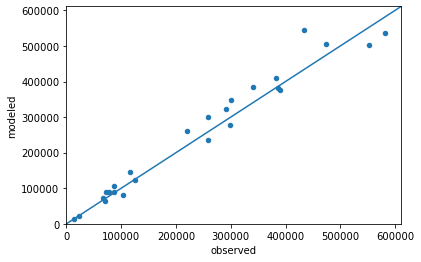

In [11]:
df = df.head(-1)
ax = df.plot(kind='scatter', x='observed', y='modeled')
lim = df[['observed','modeled']].max().max()*1.05
ax.set_ylim(0,lim)
ax.set_xlim(0,lim)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
print('r^2 : ' + str(r_value))